In [1]:
using ModelingToolkit
using NeuralPDE
using DiffEqFlux
using Flux
using Plots
using GalacticOptim
using Test
using Optim
using CUDA

In [2]:
@parameters x,y,t, θ
@variables u(..)
@derivatives Dxx''~x
@derivatives Dyy''~y
@derivatives Dtt''~t
@derivatives Dx'~x
@derivatives Dy'~y
@derivatives Dt'~t

((D'~t),)

In [3]:
cb = function (p,l)
    println("Current loss is: $l")
    return false
end

#3 (generic function with 1 method)

In [4]:
problem=1;

In [6]:
if problem == 1
name="Heat2D.pdf"
print("Solving 2D Heat equation")
  
# 3D PDE
eq  = Dt(u(x,y,t,θ)) ~ Dxx(u(x,y,t,θ)) + Dyy(u(x,y,t,θ))
# Initial and boundary conditions
bcs = [u(x,y,0,θ) ~ exp(x+y)*cos(x+y),
       u(0,y,t,θ) ~ exp(y)*cos(y+4t),
       u(1,y,t,θ) ~ exp(1+y)*cos(1+y+4t),
       u(x,0,t,θ) ~ exp(x)*cos(x+4t),
       u(x,1,t,θ) ~ exp(x+1)*cos(x+1+4t)]

analyticSol(x,y,t) = exp(x+y)*cos(x+y+4t)
end

Solving 2D Heat equation

In [7]:
domains = [ x ∈ IntervalDomain(0.0,1.),
            y ∈ IntervalDomain(0.0,1.),
            t ∈ IntervalDomain(0.0,1.)]
# Discretization
dx = 0.2; dy = 0.2; dt = 0.2;

In [8]:
chain = FastChain(FastDense(3,16,Flux.σ),FastDense(16,16,Flux.σ),FastDense(16,1))

discretization = PhysicsInformedNN([dx,dy,dt],
                                   chain,
                                   strategy = GridTraining())

pde_system = PDESystem(eq,bcs,domains,[x,y,t],[u]);
prob = discretize(pde_system,discretization);
numIter = 2000

res = GalacticOptim.solve(prob,ADAM(0.1);maxiters=numIter)
phi = discretization.phi

loss: 0.057: 100%|██████████████████████████████████████| Time: 0:04:40


#164 (generic function with 1 method)

In [9]:
# xs,ys,ts = [domain.domain.lower:dx:domain.domain.upper for (dx,domain) in zip([dx,dy,dt],domains)]

xs = range(0,stop=1,length=10)
ys = range(0,stop=1,length=10)
ts = range(0,stop=1,length=10)

u_real = [reshape([analyticSol(x,y,t) for x in xs  for y in ys], (length(xs),length(ys)))  for t in ts ];

u_predict = [reshape([first(phi([x,y,t],res.minimizer)) for x in xs  for y in ys], (length(xs),length(ys)))  for t in ts ];

┌ Info: Saved animation to 
│   fn = /Users/rajgopalnannapaneni/Dropbox/Rajgopal_Nannapaneni/PINN_Project/Heat_USER_1_ADAM_2000.gif
└ @ Plots /Users/rajgopalnannapaneni/.julia/packages/Plots/5ItHH/src/animation.jl:104


Plots.AnimatedGif("/Users/rajgopalnannapaneni/Dropbox/Rajgopal_Nannapaneni/PINN_Project/Heat_USER_1_ADAM_2000.gif")
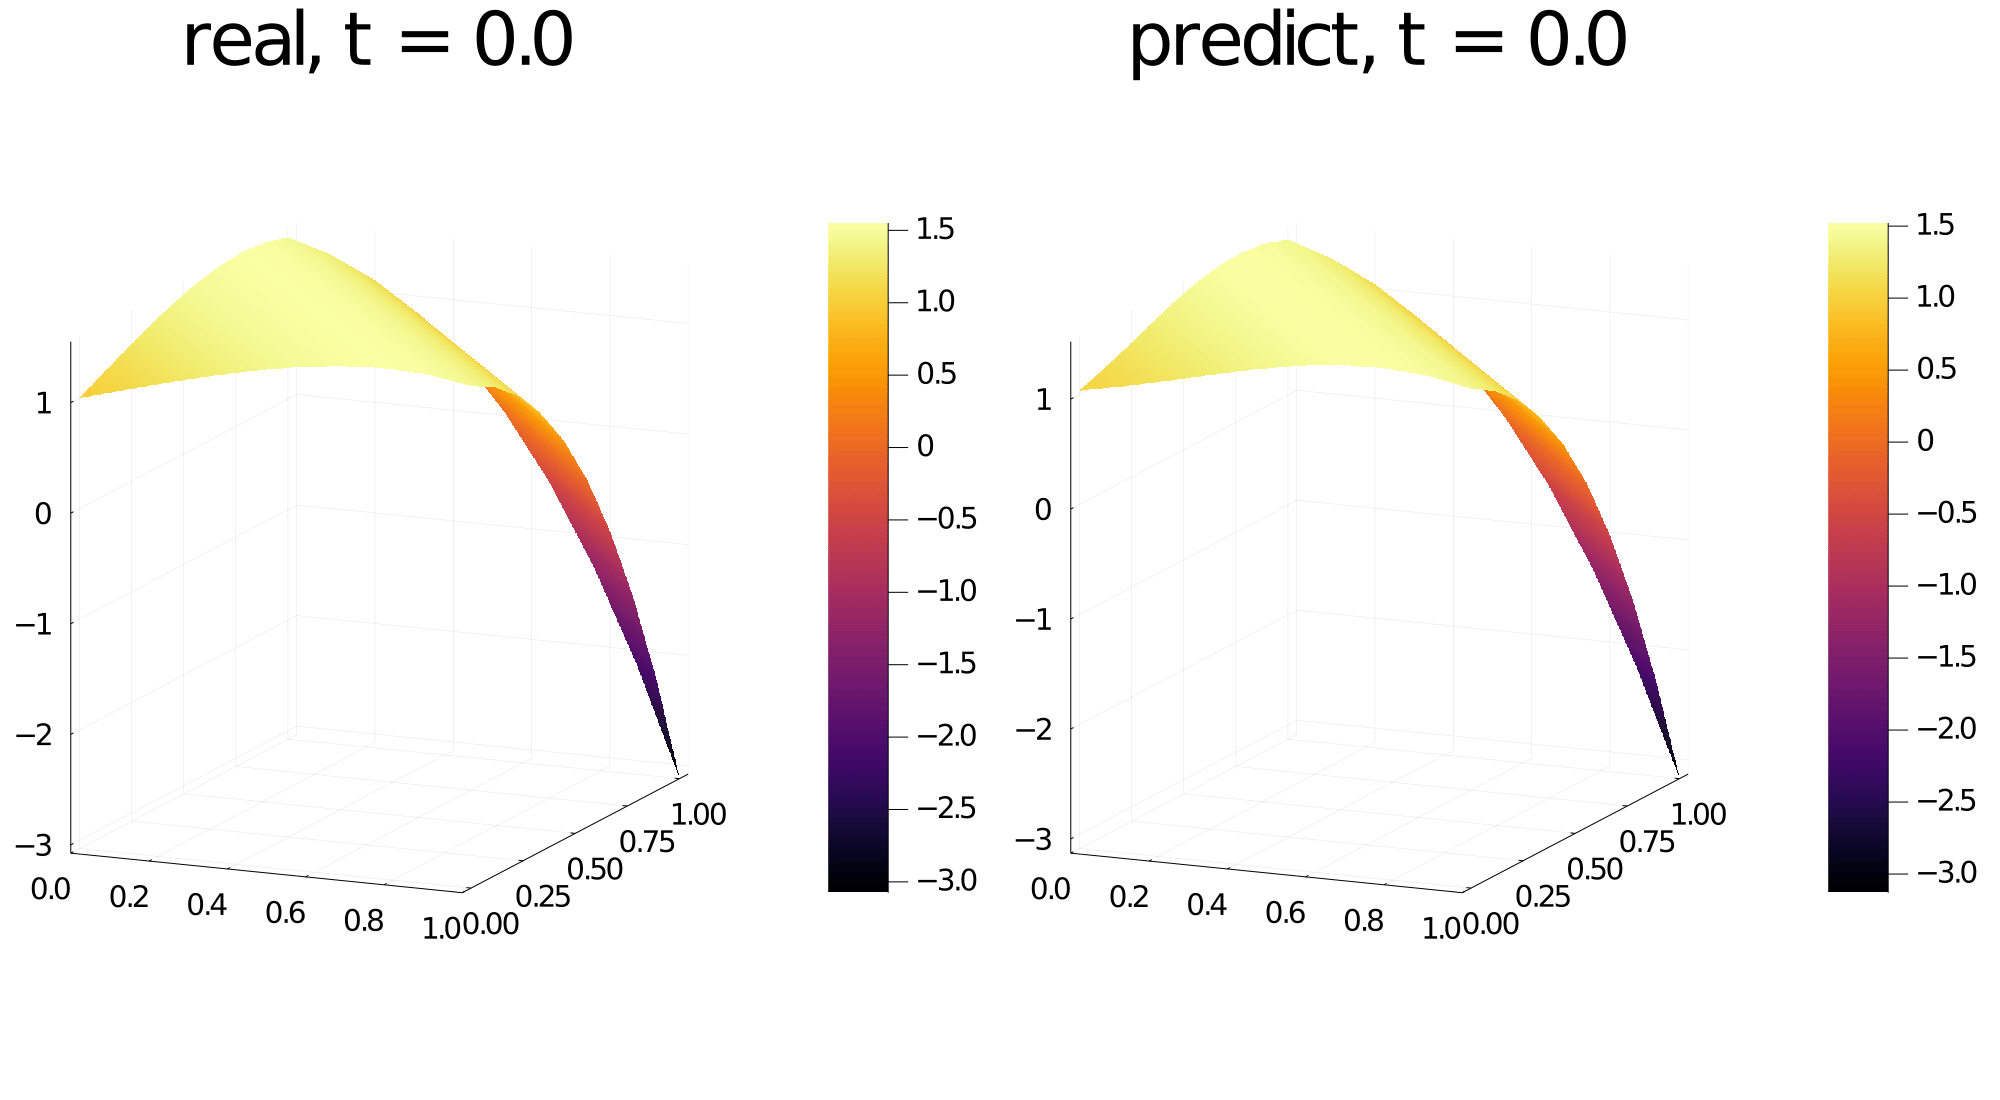

In [13]:
anim = @animate for i=1:length(ts)
  p1 = plot(xs, ys, u_real[i], st=:surface, title = "real, t = $(round(ts[i],digits=2))",titlefont=50);
  p2 = plot(xs, ys, u_predict[i], st=:surface,title = "predict, t = $(round(ts[i],digits=2))",titlefont=50);
  plot(p1,p2,layout=(1,2),aspect_ratio=:equal,size = (2000, 1100),dpi=100,
        xtickfont = font(20),ytickfont = font(20),
    ztickfont = font(20))
end
gif(anim,"Heat_USER_1_ADAM_$(numIter).gif", fps=2)

In [ ]:
anim = @animate for i=1:length(ts)
  p1 = plot(xs, ys, u_real[i], linetype=:contourf, title = "real, t = $(round(ts[i],digits=2))",titlefont=50);
  p2 = plot(xs, ys, u_predict[i], linetype=:contourf,title = "predict, t = $(round(ts[i],digits=2))",titlefont=50);
#   p3 = plot(xs, ys, u_real[i]-u_predict[i], linetype=:contourf,title = "error, t = $(ts[i])",titlefont=20);
  plot(p1,p2,layout=(1,2),aspect_ratio=:equal,size = (2200, 1100),dpi=100,
        xtickfont = font(20),ytickfont = font(20),
    ztickfont = font(20),clims=(-1.,1.))
end
# gif(anim,"wave_BFGS_3000_2.gif", fps=10)